In [3]:
import sys
import os
import pandas as pd
import graphviz
import pickle
import json
import csv

sys.path.append('../py')
from framework.utils.GitUtils import GitManager

sys.setrecursionlimit(20000) # Current limit = 999

COLORS = {
    'TestSuccess' : 'green',
    'TestFail' : 'red',
    'TestBuildError' : 'grey',
    'BuildError' : 'black'
}

In [4]:
class CommitGraph():

    def __init__(self, project, bug_id, bug_path, results_dir, root="/home/jovyan/work", restore=False):

        graph_file_path = results_dir+'graph.pickle'

        if restore and os.path.isfile(graph_file_path):
            with open(graph_file_path, 'rb') as handle:
                self.graph = pickle.load(handle)
        else:

            self.graph = {}

            commit_list = []

            # FOR EACH COMMIT
            for idx, row in pd.read_csv(bug_path+'commit_history.csv').iterrows():
                commit_path = bug_path+"commits/{id}-{c_hash}/".format(id=row['id'], c_hash=row['hash'])
                if os.path.isfile(commit_path+"result.json"):
                    gm = GitManager(
                        "{root}/projects/{project}_Bug_{bug_id}".format(root=root, bug_id=bug_id, project=project),
                        row['hash']
                    )
                    with open(commit_path+"result.json") as f:
                        raw_result = json.load(f)
                        state = 'TestSuccess'
                        if not raw_result['isSourceBuildSuccess']:
                            state = "BuildError"
                        else:
                            if not raw_result['isTestBuildSuccess']:
                                state = "TestBuildError"
                            else:
                                if not raw_result['isTestExecutionSuccess']:
                                    state = "TestFail"
                        
                        result = {
                            'id': row['id'],
                            'commit': row['hash'],
                            'Build': raw_result['isSourceBuildSuccess'],
                            'BuildTest': raw_result['isTestBuildSuccess'],
                            'ExecuteTest': raw_result['isTestExecutionSuccess'],
                            'HasTestReport': os.path.isfile(commit_path+"test-report.xml"),
                            'State': state,
                            'parents': gm.getParents(row['hash'])
                        }
                        self.graph[row['hash']] = result 
                        commit_list.append(result)
                
                #if idx > 1000: break

            # SAVE COMMIT HISTORY
            with open(results_dir+"commit_history_results.csv", 'w+') as csvfile: 
                writer = csv.DictWriter(csvfile, fieldnames = commit_list[0].keys()) 
                writer.writeheader()
                writer.writerows(commit_list)

            # ADD CHILDREN INFO
            for result in self.graph.values():
                for parent_hash in result['parents']:
                    if parent_hash == "" or parent_hash not in self.graph: continue
                    if not 'children' in self.graph[parent_hash]:
                        self.graph[parent_hash]['children'] = []
                    self.graph[parent_hash]['children'].append(result['commit'])

            # SAVE GRAPH
            with open(graph_file_path, 'wb') as handle:
                pickle.dump(self.graph, handle, protocol=pickle.HIGHEST_PROTOCOL)

            self.draw_commit_history(commit_list[0]['commit'], results_dir)

    
    def _draw(self, graph, output_dir, filename):
        dot = graphviz.Digraph()

        # Nodes
        for _, result in graph.items():

            node_id = str(result['id'])

            dot.node(result['commit'],node_id,style='filled',fontcolor='white',fillcolor=COLORS[result['State']])

        # Edges
        for _, result in graph.items():
            if result['parents'] is not None:
                for parent in result['parents']:
                    dot.edge(result['commit'], parent)

        dot.format = 'svg'
        dot.render(output_dir+"CommitGraph_"+filename)
        return dot

    def draw_commit_history(self, fix_commit_hash, output_dir):
        fix_commit = self.graph[fix_commit_hash]
        reduced_graph_1 = reduceGraph_1(self.graph, fix_commit)
        reduced_graph_2 = reduceGraph_2(self.graph, fix_commit)
        self._draw(self.graph, output_dir, "Full")
        self._draw(reduced_graph_1, output_dir, "Reduced")
        self._draw(reduced_graph_2, output_dir, "Compact")

In [5]:
def reduceGraph_1(graph, fix_commit):
    reduced_graph = {}
    reduced = []
    
    def reduceGraph_1_rec(graph, c_hash, add=True):
    
        if c_hash in reduced_graph:
            return reduced_graph[c_hash]['id'], reduced_graph[c_hash]['parents']

        if not c_hash in graph: return

        current_commit = graph[c_hash].copy()

        if not add:
            reduced.append(current_commit['id'])

        parents = current_commit['parents']
        new_parents = []

        if len(parents) == 1:
            parent_hash = parents[0]
            if parent_hash == "" or parent_hash not in graph: return "END", []
            if graph[parent_hash]['State'] == current_commit['State']:
                # Reduce
                if len(graph[parent_hash]['children']) >= 2 and current_commit['id'] not in reduced:
                    add = True
                    reduceGraph_1_rec(graph, parent_hash)
                else:

                    if len(graph[parent_hash]['parents']) >= 2:
                        reduceGraph_1_rec(graph, parent_hash)
                    else:
                        addParent = len(graph[parent_hash]['children']) >= 2
                        if addParent:
                            reduceGraph_1_rec(graph, parent_hash)
                        else:
                            last_id, new_parents = reduceGraph_1_rec(graph, parent_hash, add=False)
                            current_commit['parents'] = new_parents
                            if add:
                                current_commit['id'] = str(current_commit['id']) + "-" + str(last_id)
                            else:
                                current_commit['id'] = last_id
            else:
                reduceGraph_1_rec(graph, parent_hash)
        else:
            add = True
            for parent_hash in parents:
                reduceGraph_1_rec(graph, parent_hash)

        if add: reduced_graph[c_hash] = current_commit

        return current_commit['id'], current_commit['parents']
    
    reduceGraph_1_rec(graph, fix_commit['commit'])    
    return reduced_graph

In [6]:
def bfs(graph, init): 
    visited = []   
    queue = []  
    visited.append(init['commit'])
    queue.append(init['commit'])

    while queue:
        c_hash = queue.pop(0) 
        node = graph[c_hash].copy()         

        for parent_hash in node['parents']:
            if parent_hash not in graph: break
            parent = graph[parent_hash]
            
            if parent['State'] != node['State']:
                if len(node['parents']) >= 2:
                    return node['parents'], list(set(visited) - set(node['parents']))
                else:
                    return [parent_hash], visited
            
            if parent_hash not in visited:
                visited.append(parent_hash)
                queue.append(parent_hash)
    return None, visited

def reduceGraph_2(graph, init_commit):
    
    reduced_graph = {}
    queue = [init_commit.copy()]
    visited = [init_commit.copy()]
    
    while queue:
        
        commit = queue.pop()
        
        next_nodes, equals = bfs(graph, commit)
        if next_nodes is not None:
            for node in list(map(lambda h: graph[h], next_nodes)):
                if node not in visited:
                    visited.append(node.copy())
                    queue.append(node.copy())
            
        last_commit = graph[equals[-1]]
        commit['parents'] = next_nodes
        last_id = last_commit['id']
        if str(commit['id']) != str(last_id):
            commit['id'] = str(commit['id']) + "-" + str(last_id)
        reduced_graph[commit['commit']] = commit

    return reduced_graph

In [7]:
import copy

def reduceGraph_4(old_graph, init):
    visited = list()
    graph = copy.deepcopy(old_graph)
    reduced_graph = {}

    def dfs(visited, graph, node_hash):
        node = graph[node_hash]
        if node['commit'] not in visited:

            visited.append(node['commit'])

            if "" in node['parents']: node['parents'].remove("")

            if len(node['parents']) > 0: 

                if len(node['parents']) == 1:

                    parent = graph[node['parents'][0]]

                    new_parent = dfs(visited, graph, parent['commit'])

                    if new_parent is not None:
                        
                        if new_parent['commit'] not in reduced_graph and len(new_parent['parents']) > 0:
                            antecesor = new_parent['parents'][0]
                            node['parents'] = [antecesor]
                        else:
                            node['parents'] = [new_parent['commit']]

                    if parent['State'] != node['State'] or len(parent['children']) > 1:
                        reduced_graph[node['commit']] = node
                        return node    
                    else:
                        if new_parent is not None and len(new_parent['parents']) > 0:
                            return new_parent                    

                else:
                    reduced_graph[node['commit']] = node

                    new_parents = []
                    for parent_hash in node['parents']:
                        parent = graph[parent_hash]
                        new_parent = dfs(visited, graph, parent['commit'])

                        if new_parent['commit'] not in reduced_graph and len(new_parent['parents']) > 0:
                            antecesor = new_parent['parents'][0]
                            new_parents.append(antecesor)
                        else:
                            new_parents.append(new_parent['commit'])

                    node['parents'] = new_parents

        return node 
                    
    dfs(visited, graph, init['commit'])
    return reduced_graph

In [8]:
def reduceGraph_3(graph, init):
    visited = list()
    reduced_graph = {}

    def dfs(visited, graph, node):
        if node['commit'] not in visited:
            visited.append(node['commit'])
            print(node['id'], end=" ")

            if "" in node['parents']: return False, node
            
            if len(node['parents']) == 1:
                parent =  graph[node['parents'][0]]
                posible_path, next_node = dfs(visited, graph, parent)
                
                if not posible_path or node['Status'] != parent['Status']:
                    return False, node
                else:
                    return True, next_node
            else:
                posible_paths = True
                next_nodes = list()
                for parent_hash in node['parents']:
                    parent = graph[parent_hash]

                    posible_path, next_node = dfs(visited, graph, parent)

                    posible_paths = posible_paths and posible_path
                    next_nodes.append(next_node)
                
                if len(next_nodes) == 1:
                    return True, next_nodes[0]
                else:
                    return False, node
        return False, node

                
    dfs(visited, graph, init)
    return reduced_graph 

In [23]:
def simplify(graph, init_node):
    queue = [init_node]
    group = []
    visited = []
    
    while queue:
        
        node = queue.pop()
        visited.append(node['commit'])

        # print("["+str(node['id'])+"]", end=" ")

        if "" in node['parents']: return node, group

        if len(node['parents']) == 1:
            parent_hash = node['parents'][0]
            if parent_hash not in graph: return node, group # DELETE
            if not parent_hash in visited:
                parent =  graph[parent_hash]
                if node['State'] != parent['State']:
                    return node, group + queue
                else:
                    group.append(node['id'])
                    queue.append(parent)
        else:
            next_nodes = []
            aux_group = []
            for parent_hash in node['parents']:
                if parent_hash not in graph: return node, group # DELETE
                if not parent_hash in visited:
                    parent = graph[parent_hash]
                    
                    if node['State'] != parent['State']:
                        return node, group + queue
                    else:
                        next_node, next_group = simplify(graph, parent)
                        if next_node == parent: 
                            #print("XXX")
                            return node, group + queue
                        next_nodes.append(next_node['commit'])
                        aux_group = aux_group + next_group
                        
            if len(set(next_nodes)) == 1:
                return graph[next(iter(next_nodes))], group + queue + aux_group + [node['id']]
            else:
                return node, group + queue


    return init_node, group + queue


def reduceGraph_5(original_graph, init):

    graph = copy.deepcopy(original_graph)
    init_node = graph[init['commit']]

    simplified = []

    reduced_graph = {}
    queue = [init_node]
    visited = [init_node]
    idx = 0
    while queue:
        
        node = queue.pop()
        visited.append(node['commit'])

        next_node, simplified_nodes = simplify(graph, node)
        simplified = simplified + simplified_nodes
        
        if next_node != node:
            node['id'] = str(node['id']) + "-" + str(next_node['id'])
        node['parents'] = next_node['parents']

        reduced_graph[node['commit']] = node
        
        for parent_hash in node['parents']:
            if parent_hash not in visited and parent_hash in graph:
                parent = graph[parent_hash]
                queue.append(parent)
        
        idx = idx + 1
        print(node['id'])
        #if idx > 15: break

    return reduced_graph

In [10]:
output_dir = "results/JacksonDatabind/Bug_38/"
bug_dir = "../results/JacksonDatabind/Bug_38/"
if not os.path.isdir(output_dir): 
    os.makedirs(output_dir)
g = CommitGraph("JacksonDatabind", 38, bug_dir, output_dir, restore=True)

564 565 566 567 14_20
568 17_20
569 16_20
8_12
570 10_12
571 13_12
572 14_20
573 17_20
574 16_20
9_12
575 13_12
576 14_20
577 17_20
578 16_20
579 580 16_20
581 582 583 64_88
584 512_88
585 552_88
586 561_88
587 587_88
588 616_88
589 591_636
590 794_636
591 795_852
592 583_590
593 591_590
594 794_590
595 795_852
596 592_852
597 560_582
598 591_582
599 794_582
600 795_852
601 592_852
602 538_559
603 561_559
604 587_559
605 616_559
606 591_636
607 794_636
608 795_852
609 583_590
610 591_590
611 794_590
612 795_852
613 592_852
614 560_582
615 591_582
616 794_582
617 795_852
618 592_852
619 514_559
620 552_559
621 561_559
622 587_559
623 616_559
624 591_636
625 794_636
626 795_852
627 583_590
628 591_590
629 794_590
630 795_852
631 592_852
632 560_582
633 591_582
634 794_582
635 795_852
636 592_852
637 538_559
638 561_559
639 587_559
640 616_559
641 591_636
642 794_636
643 795_852
644 583_590
645 591_590
646 794_590
647 795_852
648 592_852
649 560_582
650 591_582
651 794_582
652 795_852
653

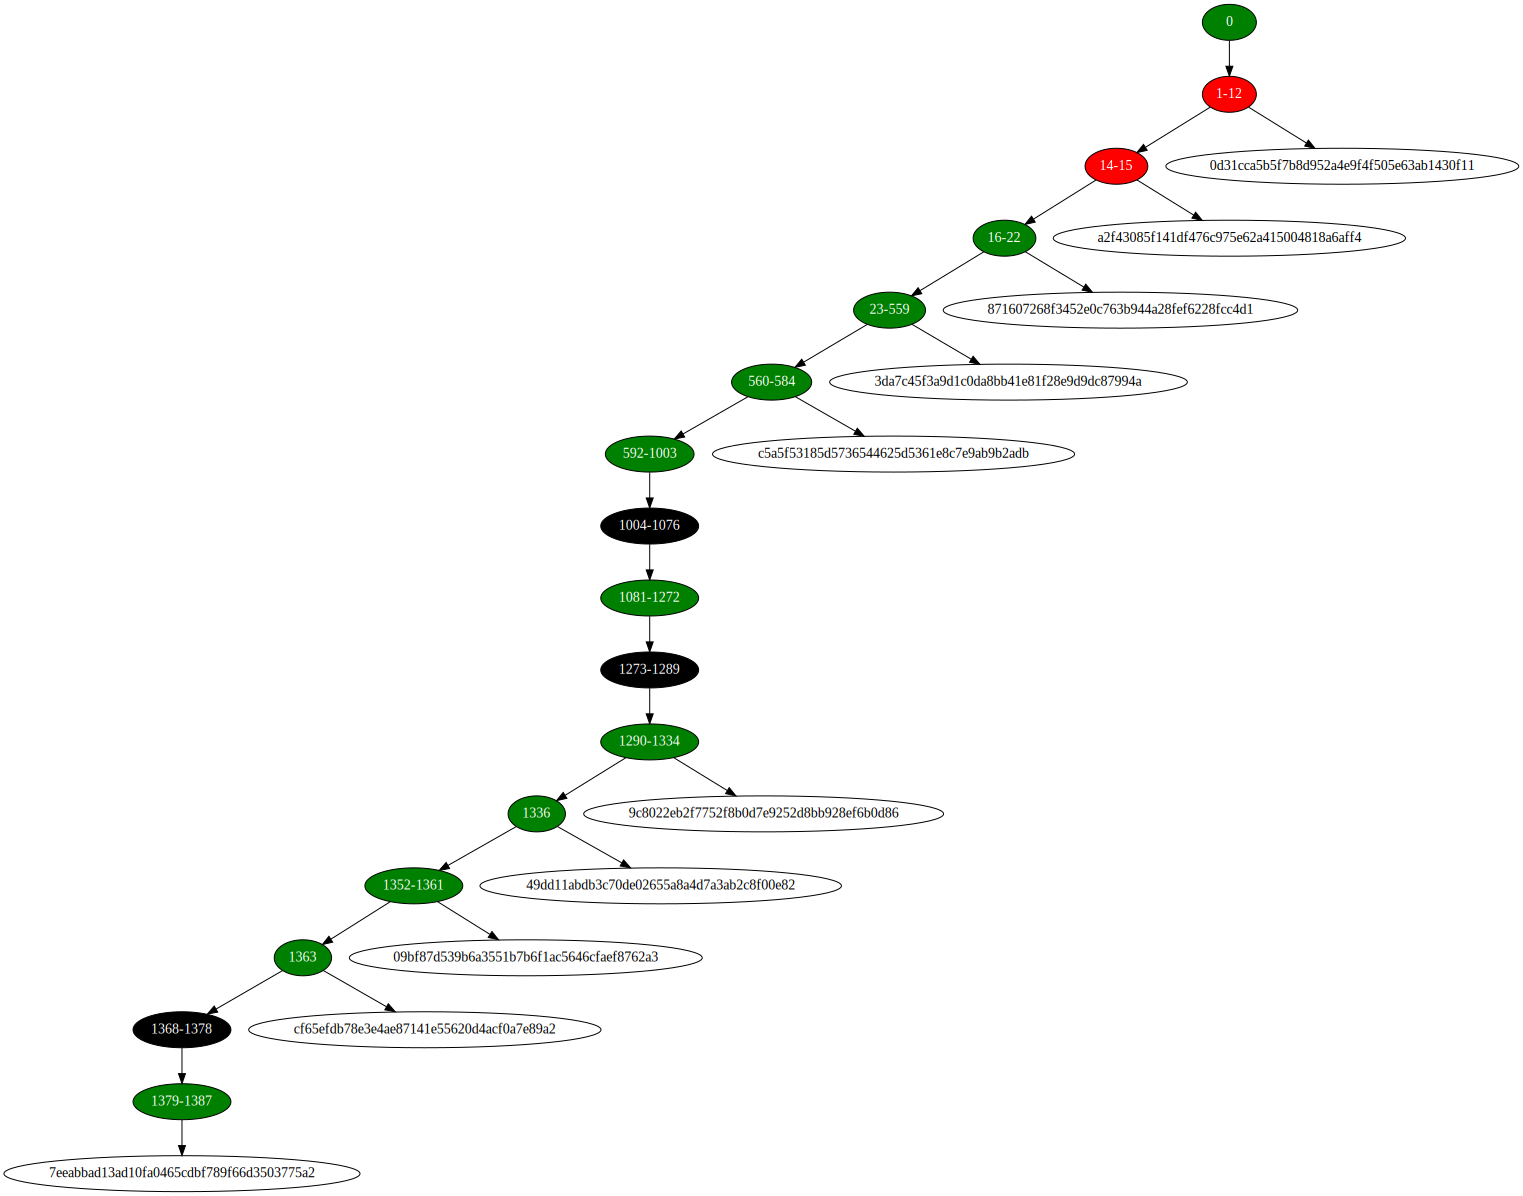

In [25]:
fix_hash = "21a2e4b7d680bf796f07d5d3b6119a3cd3fc356c"
fix_commit = g.graph[fix_hash]
#reduced_graph_4 = reduceGraph_4(g.graph, fix_commit)
# g._draw(reduced_graph_2, output_dir, "Prueba")
#reduced_graph_5 = reduceGraph_5(reduced_graph_4, fix_commit)
reduced_graph_5 = reduceGraph_5(g.graph, fix_commit)
#reduced_graph_5
g._draw(reduced_graph_5, output_dir, "Prueba")